In [1]:
import os
import glob

# Now i'm trying this one.
model_folder = '../outputs/crepe-20211128-221134/'

model_paths = glob.glob(os.path.join(model_folder, '*'))

In [2]:
import sys
sys.path.append('/home/jxm3/research/transcription/contrastive-pitch-detection')

In [123]:
from models.crepe import CREPE
from models.contrastive import ContrastiveModel

min_midi = 21
max_midi = 108
def get_model():
    num_output_nodes = 256 # contrastive embedding dim
    out_activation = None
    
    model = CREPE(
        model='tiny',
        num_output_nodes=num_output_nodes, 
        load_pretrained=False,
        out_activation=out_activation
    )
    
    return ContrastiveModel(model, min_midi, max_midi, num_output_nodes)

In [152]:
import glob
import natsort
import os
import torch

model_paths = glob.glob(os.path.join(model_folder, '*'))

model_path = natsort.natsorted(model_paths)[-2]
print('loaded model from:', model_path)

model = get_model()
model.load_state_dict(torch.load(model_path)['model'])

loaded model from: ../outputs/crepe-20211128-221134/59_epochs.pth


<All keys matched successfully>

In [6]:
# from dataloader.nsynth import load_nsynth
# dataset = load_nsynth('test', 'keyboard')

from dataloader.nsynth_chords import load_nsynth_chords
dataset = load_nsynth_chords('test')

print('loaded', len(dataset), 'tracks')

import random
random.shuffle(dataset)

loaded 993 tracks


In [141]:
import numpy as np
from utils.misc import midi_vals_to_categorical, hz_to_midi_v

batch_size = 512

min_midi = 21
max_midi = 108

x = []
y = []
all_midis = []

for i in range(batch_size):
    track = dataset[i]
    start_idx = 0
    end_idx = 16_000
    #
    audio = torch.tensor(track.waveform[start_idx : end_idx], dtype=torch.float32)
    x.append(audio)
    #
    frequencies = track.get_frequencies_from_offset(start_idx, end_idx)
    midis = np.rint(hz_to_midi_v(frequencies))
    all_midis.append(list(midis))
    categorical = midi_vals_to_categorical(midis, min_midi, max_midi)
    y.append(torch.tensor(categorical, dtype=torch.float32))
x = torch.stack(x)
y = torch.stack(y)
print('loaded audio batch of shape:', x.shape, 'with labels', y.shape)

loaded audio batch of shape: torch.Size([512, 16000]) with labels torch.Size([512, 88])


In [148]:
(normalized_audio_embeddings @ normalized_audio_embeddings.T)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       grad_fn=<MmBackward0>)

In [149]:
(normalized_chord_embeddings @ normalized_chord_embeddings.T)

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       grad_fn=<MmBackward0>)

<AxesSubplot:ylabel='Count'>

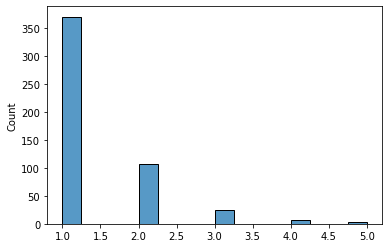

In [56]:
import seaborn as sns
sns.histplot(y.sum(1)) # validation set chord distribution (by num. notes)

In [57]:
from IPython.display import Audio
Audio(data=x[0], rate=16000)

In [173]:
A = sns.heatmap(logits.detach(), vmin=-1, vmax=1)
A.set(title='Heatmap of logits')
print(A)

tensor(1., requires_grad=True)

In [153]:
audio_embeddings = model(x)
note_labels = y

#### Taken from ContrastiveModel.contrastive_loss() ####
batch_size, num_notes = note_labels.shape
assert num_notes == model.num_labels
chord_embeddings = model.encode_note_labels(note_labels)
assert chord_embeddings.shape == audio_embeddings.shape
# Normalize embeddings.
normalized_audio_embeddings = audio_embeddings / torch.norm(audio_embeddings, p=2, dim=1, keepdim=True)
normalized_chord_embeddings = chord_embeddings / torch.norm(chord_embeddings, p=2, dim=1, keepdim=True)
logits = torch.matmul(normalized_audio_embeddings, normalized_chord_embeddings.T) * torch.exp(model.temperature)
# Symmetric loss function
labels = (note_labels[:,None] == note_labels).all(2).type(torch.float32)
labels = labels / labels.sum(1)
loss_a = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)
loss_n = torch.nn.functional.binary_cross_entropy_with_logits(logits.T, labels)
loss = (loss_a + loss_n)/2
print(loss)

tensor(0.0692, grad_fn=<DivBackward0>)


In [154]:
torch.nn.CosineSimilarity(1)(
    model(x[None, 44]),
    model(x[None, 1])
)

tensor([1.0000], grad_fn=<DivBackward0>)

In [163]:
# What would the loss be if everything was equally similar?
uniform_logits = -1 * torch.ones_like(logits) * 2.71
u_loss_a = torch.nn.functional.binary_cross_entropy_with_logits(uniform_logits, labels)
u_loss_n = torch.nn.functional.binary_cross_entropy_with_logits(uniform_logits.T, labels)
print( (u_loss_a + u_loss_n) / 2 )

tensor(0.0697)


In [60]:
print(loss_a.item(), '//', loss_n.item())

0.06921125203371048 // 0.06921125203371048


In [61]:
torch.nn.functional.binary_cross_entropy_with_logits(logits, labels)

tensor(0.0692, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

<AxesSubplot:>

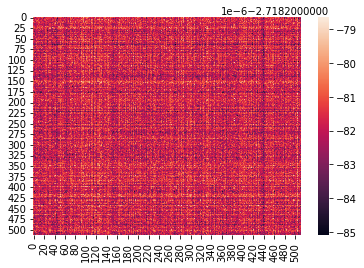

In [121]:
import seaborn as sns
sns.heatmap(logits.detach()) # true model output (no softmax)

In [126]:
logits[0]

tensor([-2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183, -2.7183,
        -2.7183, -2.7183, -2.7183, -2.71

<AxesSubplot:>

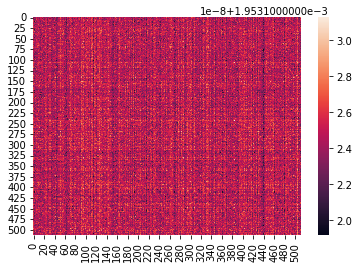

In [64]:
import seaborn as sns
sns.heatmap(torch.nn.functional.softmax(logits.detach(), 1)) # true model output (with softmax over dim 1)

In [118]:
logits.detach()

tensor([[-2.7183, -2.7183, -2.7183,  ..., -2.7183, -2.7183, -2.7183],
        [-2.7183, -2.7183, -2.7183,  ..., -2.7183, -2.7183, -2.7183],
        [-2.7183, -2.7183, -2.7183,  ..., -2.7183, -2.7183, -2.7183],
        ...,
        [-2.7183, -2.7183, -2.7183,  ..., -2.7183, -2.7183, -2.7183],
        [-2.7183, -2.7183, -2.7183,  ..., -2.7183, -2.7183, -2.7183],
        [-2.7183, -2.7183, -2.7183,  ..., -2.7183, -2.7183, -2.7183]])

<AxesSubplot:>

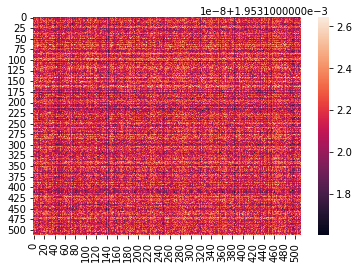

In [65]:
import seaborn as sns
sns.heatmap(torch.nn.functional.softmax(logits.detach(),dim=1)) # true model output (with softmax over dim 0)

<AxesSubplot:>

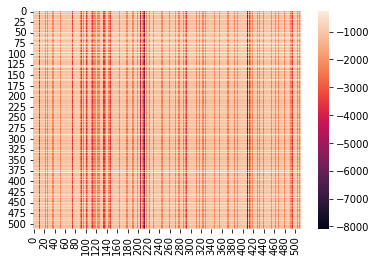

In [66]:
unnorm_logits = (audio_embeddings @ chord_embeddings.T) * torch.exp(model.temperature)
import seaborn as sns
sns.heatmap(unnorm_logits.detach()) # true model output

<AxesSubplot:>

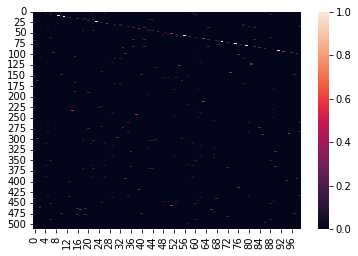

In [74]:
import seaborn as sns
sns.heatmap(labels.detach()[:,:100]) # desird model output

In [79]:
((labels.sum(0) - 1).abs() < .0001).all() # check integrity of label distributions

tensor(True)

In [ ]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(chord_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(num_notes):
    emb_colors.append(colors[round(y[i].sum().item())])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Chord embeddings colored by number of notes.

tensor(44)

<ipython-input-104-3c6dd418c1b5>:17: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  emb_markers.append(markers[avg_note // 12]) # mark by octave


Text(0.5, 1.0, 'Chord embeddings (color=note, shape=octave)')

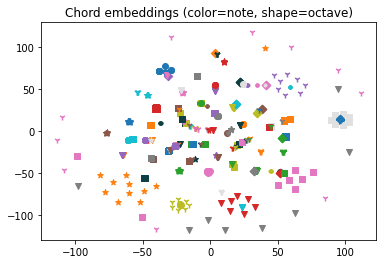

In [104]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(chord_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
markers = ['.', 'o', 'v', '1', 's', '*', 'D', 'X']

emb_colors = []
emb_markers = []
for i in range(num_notes):
    avg_note = y[i].nonzero().float().mean().int()
    emb_markers.append(markers[avg_note // 12]) # mark by octave
    first_note = y[i].nonzero()[0,0]
    emb_colors.append(colors[first_note % 12]) # color by note
    plt.scatter(emb_dim_2[i,0], emb_dim_2[i,1], c=emb_colors[i], marker=emb_markers[i]) # Chord embeddings colored by number of notes.
plt.title('Chord embeddings (color=note, shape=octave)')

<ipython-input-107-b3546f02adb4>:17: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  emb_markers.append(markers[avg_note // 12]) # mark by octave


Text(0.5, 1.0, 'Audio embeddings (color=note, shape=octave)')

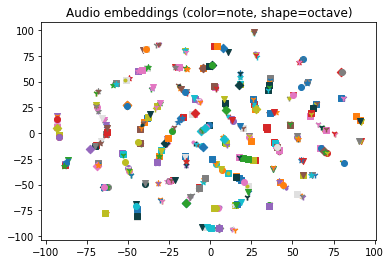

In [107]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = audio_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=2, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(audio_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
markers = ['.', 'o', 'v', '1', 's', '*', 'D', 'X']

emb_colors = []
emb_markers = []
for i in range(num_notes):
    avg_note = y[i].nonzero().float().mean().int()
    emb_markers.append(markers[avg_note // 12]) # mark by octave
    first_note = y[i].nonzero()[0,0]
    emb_colors.append(colors[first_note % 12]) # color by note
    plt.scatter(emb_dim_2[i,0], emb_dim_2[i,1], c=emb_colors[i], marker=emb_markers[i]) # Chord embeddings colored by number of notes.
plt.title('Audio embeddings (color=note, shape=octave)')

In [97]:
len(chord_embeddings)

512

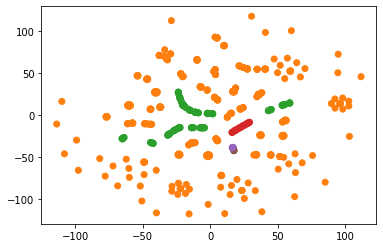

In [75]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(chord_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(num_notes):
    emb_colors.append(colors[round(y[i].sum().item())])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Chord embeddings colored by number of notes.

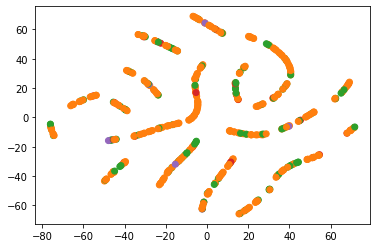

In [76]:
import sklearn
import matplotlib.pyplot as plt

num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(audio_embeddings.detach())
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(num_notes):
    emb_colors.append(colors[round(y[i].sum().item())])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Audio embeddings colored by number of notes.

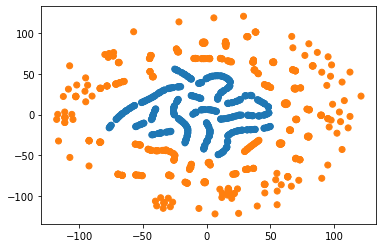

In [69]:
import sklearn
import matplotlib.pyplot as plt

all_embeddings = torch.cat([audio_embeddings, chord_embeddings]).detach()
num_notes, emb_dim = chord_embeddings.shape
# create the TSNE
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5, learning_rate='auto', init='random')
emb_dim_2 = tsne.fit_transform(all_embeddings)
# 12 colors, one per note
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
          '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#0e3f43', '#e0e0e0']
emb_colors = []
for i in range(len(all_embeddings)):
    ci = 0 if i < num_notes else 1 # make chord and audio embeddings different colors
    emb_colors.append(colors[ci])
# scatterplot of TSNE results
plt.scatter(emb_dim_2[:,0], emb_dim_2[:,1], c=emb_colors) # Audio vs. chord embeddings. (audio are blue)

In [70]:
import functools
softmax = functools.partial(torch.nn.functional.softmax, dim=1)

<AxesSubplot:>

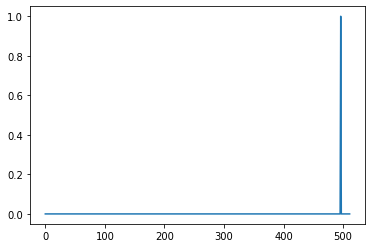

In [108]:
import pandas as pd
A=pd.Series(softmax(chord_embeddings[None, 0] @ audio_embeddings.T).detach().squeeze().cpu().numpy())
A.plot()